## **Задание 1**

[Набор данных](../data/places.csv)

```python
# Наименование столбцов
['ID', 'Name', 'global_id', 'IsNetObject', 'OperatingCompany', 'TypeObject', 'AdmArea', 'District', 'Address', 'PublicPhone', 'SeatsCount', 'SocialPrivileges', 'Longitude_WGS84', 'Latitude_WGS84', 'geoData']
```

⚠️ **Замечание**: 1) для парсинга данных используйте модуль `csv`; 2) для вычисления расстояния используйте формулу гаверсинуса.

1. Рассчитайте расстояние от заданной точки (`lat=55.751244`, `lng=37.618423`) до каждого заведения общепита из набора данных. Выведите первые 10. 
2. Рассчитайте расстояние между всеми заведениями общепита из набора данных. Выведите первые 10.
3. Выведите топ-10 наиболее близких и наиболее отдаленных заведений.


Формула гаверсинуса:

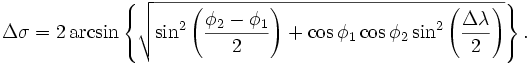

In [1]:
from pyspark import SparkConf, SparkContext
import math
import csv
import os
import io

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def parse(line):
    reader = csv.reader(io.StringIO(line))
    row = next(reader)
    if len(row) >= 14:
        return (row[1], float(row[12]), float(row[13]))

In [3]:
PATH = os.path.abspath("places.csv")
PATH

'/Users/dmitryromanov/Desktop/BigData_uni/hw1/places.csv'

In [4]:
file_path = f"file://{PATH}"

In [5]:
conf = SparkConf().setAppName("HW1").set("spark.driver.host", "127.0.0.1").set("spark.driver.bindAddress", "127.0.0.1")
sc = SparkContext(conf=conf)

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/09 22:17:41 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
ref_lat, ref_lon = 55.751244, 37.618423

places_rdd = sc.textFile(file_path).map(parse).filter(lambda x: x is not None)
data = places_rdd.collect()
places_rdd.take(5)

[('Шоколадница', 37.678681276899106, 55.77302899555391),
 ('МУ-МУ', 37.678960226636995, 55.771586681103294),
 ('КОМБИНАТ ПИТАНИЯ МГТУ ИМ.Н.Э.БАУМАНА',
  37.679609224948955,
  55.76545455297085),
 ('Дом 12', 37.661498425199866, 55.762608795785084),
 ('Чито-Ра', 37.662845514876196, 55.7622012817049)]

In [7]:
print(f"Загружено: {len(data)} заведений\n")

Загружено: 769 заведений



1. Рассчитайте расстояние от заданной точки (`lat=55.751244`, `lng=37.618423`) до каждого заведения общепита из набора данных. Выведите первые 10. 

In [8]:
dist_rdd = places_rdd.map(lambda p: (haversine(ref_lat, ref_lon, p[2], p[1]), p[0]))
dist_rdd.sortBy(lambda x: x[0], numPartitions=1).take(10)

for dist, name in dist_rdd.sortBy(lambda x: x[0], numPartitions=1).take(10):
    print(f"{name} -- {round(dist, 4)} km")

Мареа -- 1.056 km
Стейк Хаус «Бизон» -- 1.059 km
ЛяМур -- 1.0653 km
БИБЛИОТЕКА Shisha Lounge -- 1.066 km
Му-Му -- 1.066 km
Unlock cafe -- 1.0684 km
Папа Джонс -- 1.0685 km
Jimmy Poy -- 1.0689 km
Шоколадница -- 1.0699 km
Настоишная -- 1.07 km


2. Рассчитайте расстояние между всеми заведениями общепита из набора данных. Выведите первые 10.

In [9]:
pairs_rdd = (places_rdd.cartesian(places_rdd).filter(lambda ab: ab[0][0] < ab[1][0]).map(lambda ab: (haversine(ab[0][2], ab[0][1], ab[1][2], ab[1][1]), ab[0][0], ab[1][0]))).filter(lambda x: x[0] > 0)

for dist, n1, n2 in pairs_rdd.sortBy(lambda x: x[0], numPartitions=1).take(10):
    print(f"{n1} - {n2} -- {round(dist, 4)} km")

Во сколько начинается аперитив - Одесса -мама -- 0.0008 km
Во сколько начинается аперитив - Хачапури -- 0.0008 km
JACK AND JANE - Крапива -- 0.0008 km
JACK AND JANE - Юнион Джек -- 0.0008 km
Bolivar - JACK AND JANE -- 0.0008 km
Castle DiSH - Честная кухня -- 0.001 km
Натахтари - Теремок -- 0.0013 km
Drunk Punk Craft Bar - Хинкальная на Арме -- 0.0015 km
Drunk Punk Craft Bar - Прайм стар -- 0.0015 km
MISSION - Может, кофе -- 0.0019 km


3. Выведите топ-10 наиболее близких и наиболее отдаленных заведений.


In [10]:
print("ближайшие:")
for dist, name in dist_rdd.sortBy(lambda x: x[0], numPartitions=1).take(10):
    print(f"{name} -- {round(dist, 4)}")

print()


print("самые дальние:")
for dist, name in dist_rdd.top(10, key=lambda x: x[0]):
    print(f"{name} -- {round(dist, 4)} km")

ближайшие:
Мареа -- 1.056
Стейк Хаус «Бизон» -- 1.059
ЛяМур -- 1.0653
БИБЛИОТЕКА Shisha Lounge -- 1.066
Му-Му -- 1.066
Unlock cafe -- 1.0684
Папа Джонс -- 1.0685
Jimmy Poy -- 1.0689
Шоколадница -- 1.0699
Настоишная -- 1.07

самые дальние:
МНИТИ -- 6.4269 km
Школа 414 -- 6.2934 km
Византия -- 6.1325 km
Школа 435 -- 6.0873 km
Мята Lounge -- 6.0393 km
Ля Фантази -- 5.9546 km
ШефДонер -- 5.9546 km
Take & Wake -- 5.9546 km
Пекинский Сад -- 5.8992 km
Гриль и Сувлаки -- 5.8955 km


In [11]:
sc.stop()